# Pleiades 2nd Order ODE Problem

## Loading packages

In [ ]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates

In [2]:
#plotly()

## Initial value problem: Pleiades

In [3]:
u0=[3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
    3.0,-3.0,2.0,0,0,-4.0,4.0,    
    0,0,0,0,0,1.75,-1.5,
    0,0,0,-1.25,1,0,0]

q0=u0[1:14]
v0=u0[15:28]

t0=0.0
t1=3.0

tspan=(t0,t1);

## Ode problem

In [4]:
f = (du,u,p,t) -> begin
  @inbounds begin
  x = view(u,1:7)   # x
  y = view(u,8:14)  # y
  v = view(u,15:21) # x′
  w = view(u,22:28) # y′
  du[1:7] .= v
  du[8:14].= w
  for i in 15:28
    du[i] = zero(u[1])
  end
  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      du[14+i] += j*(x[j] - x[i])/r
      du[21+i] += j*(y[j] - y[i])/r
    end
  end
  end
end

#3 (generic function with 1 method)

In [5]:
prob = ODEProblem(f,u0,tspan);
sol1 = @btime (solve(prob,Vern9(),abstol=1e-12,reltol=1e-12));

  18.871 ms (26412 allocations: 2.13 MiB)


In [6]:
setprecision(BigFloat,106)
u0128=BigFloat.(u0)
Gm128=BigFloat.([1,2,3,4,5,6,7])
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(f,u0128,tspan128);
sol = @time (solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20));
test_sol = TestSolution(sol);

 53.665726 seconds (145.51 M allocations: 6.276 GiB, 6.18% gc time)


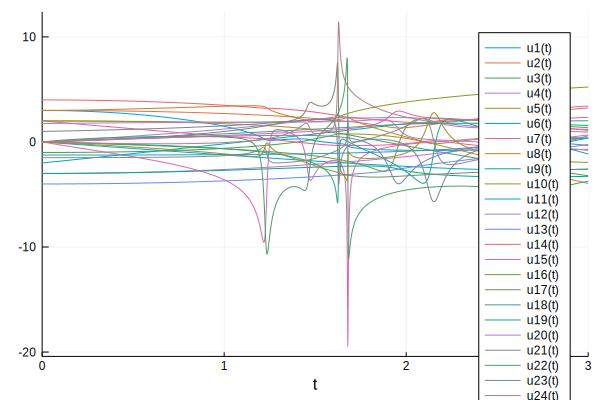

In [7]:
plot(sol1)

## DynamicalODEProblem

In [8]:
dotv = (dv,q,v,par,t) -> begin
  @inbounds begin
  x = view(q,1:7)   # x
  y = view(q,8:14)  # y
  vx = view(v,1:7)   # x′
  vy = view(v,8:14)  # y′
  for i in 1:14
    dv[i] = zero(x[1])
  end
  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      dv[i] += j*(x[j] - x[i])/r
      dv[7+i] += j*(y[j] - y[i])/r
    end
  end
  end
end

#6 (generic function with 1 method)

In [9]:
dotq = (dq,q,v,par,t) -> begin
  @inbounds begin
  x = view(q,1:7)   # x
  y = view(q,8:14)  # y
  vx = view(v,1:7)   # x′
  vy = view(v,8:14)  # y′
  dq[1:7] .= vx
  dq[8:14].= vy
  end
end

#8 (generic function with 1 method)

In [10]:
q0=u0[1:14]
v0=u0[15:28]
probpart = DynamicalODEProblem(dotq,dotv,q0,v0,tspan);

In [11]:
sol11 = @btime (solve(probpart,Vern9(),abstol=1e-12,reltol=1e-12));

  23.641 ms (197972 allocations: 6.34 MiB)


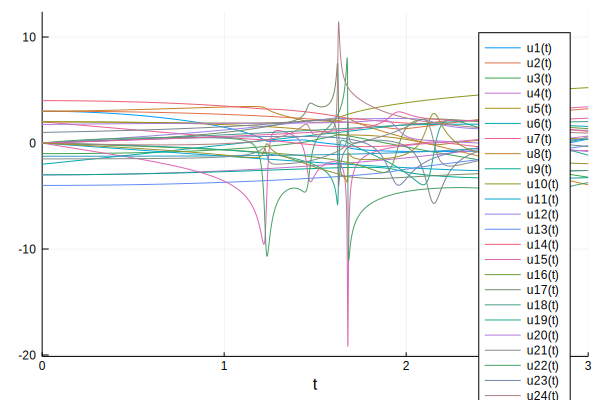

In [12]:
plot(sol11)

In [13]:
typeof(sol11.u)

Array{RecursiveArrayTools.ArrayPartition{Float64,Tuple{Array{Float64,1},Array{Float64,1}}},1}

## 2nd Order Problem

In [14]:
function f2nd!(ddu,du,u,p,t)
  @inbounds begin
  x = view(u,1:7)   # x
  y = view(u,8:14)  # y
  vx = view(du,1:7) # x′
  vy = view(du,8:14) # y′

  for i in 1:14
    ddu[i] = zero(x[1])
  end

  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      ddu[i] += j*(x[j] - x[i])/r
      ddu[7+i] += j*(y[j] - y[i])/r
    end
  end
  end
end


f2nd! (generic function with 1 method)

In [15]:
prob2nd = SecondOrderODEProblem(f2nd!,v0,q0,tspan);

In [16]:
sol21 = @btime (solve(prob2nd,Vern9(),abstol=1e-12,reltol=1e-12));

  23.102 ms (175116 allocations: 5.29 MiB)


In [17]:
sol22 = @btime (solve(prob2nd,DPRKN12(),abstol=1e-12,reltol=1e-12));

  12.397 ms (4000 allocations: 280.42 KiB)


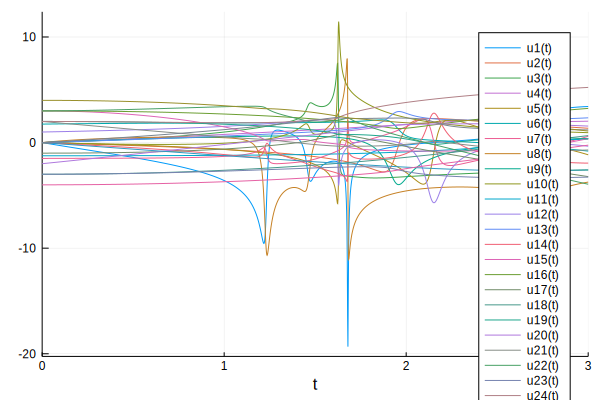

In [18]:
plot(sol22)

In [19]:
typeof(sol21.u)

Array{RecursiveArrayTools.ArrayPartition{Float64,Tuple{Array{Float64,1},Array{Float64,1}}},1}

## Energy Error

In [20]:
function NbodyEnergy(u, Gm)
"""    
     Nbody problem Hamiltonian (Cartesian Coordinates)     
"""    
    
    # Declarations 
    
    dim=2   
    nbody=length(Gm)
    
    # Implementation

 @inbounds begin
    x = view(u,1:7)   # x
    y = view(u,8:14)  # y
    v = view(u,15:21) # x′
    w = view(u,22:28) # y′
   
    H=0.
    P=0.
    
    for i in 1:nbody
        H+=Gm[i]*(v[i]*v[i]+w[i]*w[i])                       
        for j in i+1:nbody           
            r = ((x[i]-x[j])^2+(y[i]-y[j])^2)^(1/2)
            P+=(Gm[i]/r)*Gm[j]
        end
    end
    
    return(H/2-P)
    end
        
end

NbodyEnergy (generic function with 1 method)

In [21]:
E0=NbodyEnergy(u0128,Gm128)

ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol1.u)./E0.-1
ΔE11 = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol11.u)./E0.-1;
ΔE21 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol21.u)./E0.-1
ΔE22 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol22.u)./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE22))))

(3.1617187f-12, 1.7817413f-12, 1.7817413f-12, 6.856295f-14)

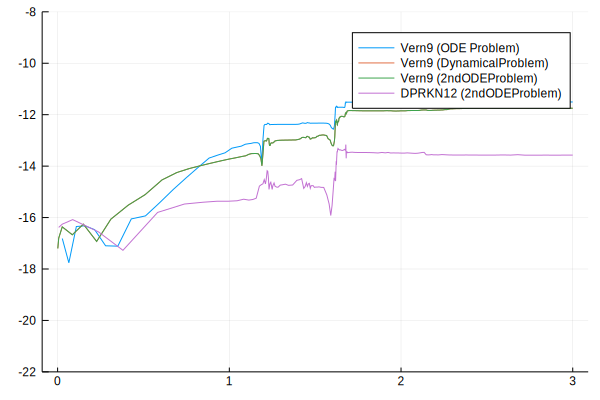

In [22]:
ylimit1=-22
ylimit2=-8
plot(sol1.t,log10.(abs.(ΔE1)), label="Vern9 (ODE Problem)",
     ylims=(ylimit1,ylimit2),)
plot!(sol11.t,log10.(abs.(ΔE11)), label="Vern9 (DynamicalProblem)",
     ylims=(ylimit1,ylimit2),)
plot!(sol21.t,log10.(abs.(ΔE21)), label="Vern9 (2ndODEProblem)",
     ylims=(ylimit1,ylimit2),)
plot!(sol22.t,log10.(abs.(ΔE22)), label="DPRKN12 (2ndODEProblem)",
     ylims=(ylimit1,ylimit2),)

## Work-Precision diagrams

In [23]:
abstols = 1.0 ./ 10.0 .^ (8:10)
reltols = 1.0 ./ 10.0 .^ (8:10);

In [24]:
#
# Errorea ematen du
#
#setups = [
#          Dict(:alg=>Vern9())
#]
#wp = WorkPrecisionSet(probpart,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100,maxiters=100000)
#plot(wp)